# PYCE Loans Model

### Machine Learning Model for calculating the probability of loan default and estimating interest rates to maximize profits

### Methods used and compared: Linear Regression, Logistic Regression, Random Forest

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import time
import warnings
warnings.filterwarnings("ignore")

## Importing Stage 1 results

In [84]:
results = pd.read_csv('Result_Stage1_25.csv').drop('id', axis = 1)
results

,own,competing1,competing3,borrowertype,accepted,default,profit
0,NaN,0.405000,0.236840,0,0,0,NaN
1,NaN,0.092714,0.152445,2,0,1,NaN
2,NaN,0.060536,NaN,0,0,0,NaN
3,0.040365,0.159082,0.004469,0,0,0,NaN
4,NaN,0.944560,0.297304,3,0,0,NaN
...,...,...,...,...,...,...,...
99995,0.060634,0.088147,0.165407,0,1,0,606.34381
99996,NaN,0.234034,NaN,0,0,0,NaN
99997,NaN,0.193021,0.178011,0,0,0,NaN
99998,NaN,0.300000,0.125500,0,0,0,NaN


In [4]:
results.describe().round(3)

,own,competing1,competing3,borrowertype,accepted,default,profit
count,20908.000,93772.000,73433.000,100000.00,100000.000,100000.000,12005.000
mean,0.059,0.262,0.253,0.60,0.120,0.198,-101.403
std,0.017,0.211,0.167,1.02,0.325,0.398,2658.640
min,0.040,0.000,0.000,0.00,0.000,0.000,-10000.000
25%,0.043,0.103,0.142,0.00,0.000,0.000,433.464
50%,0.055,0.224,0.214,0.00,0.000,0.000,562.741
75%,0.073,0.383,0.316,1.00,0.000,0.000,738.773
max,0.093,1.000,1.000,3.00,1.000,1.000,926.195


### Distribution of interest rates

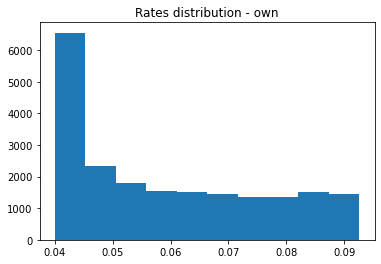

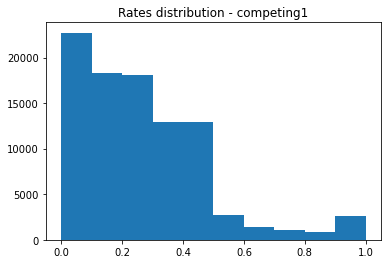

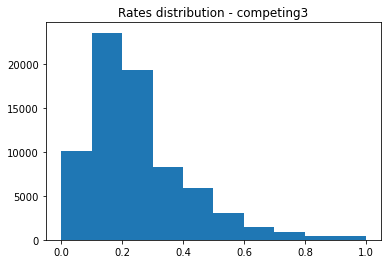

In [5]:
plt.hist(results.own)
plt.title('Rates distribution - own')
plt.show()

plt.hist(results.competing1)
plt.title('Rates distribution - competing1')
plt.show()

plt.hist(results.competing3)
plt.title('Rates distribution - competing3')
plt.show()


## Functions

- Calculate our profit based on the competitors' interest rate and on the borrower preferences. We can use it to simulate different strategies
- Calculate competing1 and competing3 performance

In [86]:
def calculate_profit(row):
    if np.isnan(row.rate):
        return np.nan
    elif np.isnan(row.competing1) and np.isnan(row.competing3):
        return aux(row.default, row.rate)
    elif np.isnan(row.competing1):
        if row.borrowertype != 3 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing3 < 0.01999999:
            return aux(row.default, row.rate)
        else:
            return np.nan
    elif np.isnan(row.competing3):
        if row.borrowertype != 1 and row.rate < row.competing1:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing1 < 0.01999999:
            return aux(row.default, row.rate)
        else:
            return np.nan
    else: #all bid
        if row.borrowertype == 0 and row.rate < row.competing1 and row.rate < row.competing3:
            return aux(row.default, row.rate)
        elif row.borrowertype == 1 and row.rate < row.competing3 and row.competing1 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        elif row.borrowertype == 2 and row.rate - row.competing1 < 0.0199999 and row.rate - row.competing3 < 0.01999999:
            return aux(row.default, row.rate)
        elif row.borrowertype == 3 and row.rate < row.competing1 and row.competing3 - row.rate > 0.0200001:
            return aux(row.default, row.rate)
        else:
            return np.nan

In [87]:
def aux(default, competing1):
    if default:
        return -10000
    return 10000*competing1

def profit1(row):
    
    # No bid
    if np.isnan(row.competing1):
        return np.nan
    
    #Only bid
    elif np.isnan(row.own) and np.isnan(row.competing3):
        return aux(row.default, row.competing1)
    
    #Competes only with competing3
    elif np.isnan(row.own):
        if row.borrowertype != 3 and row.competing1 < row.competing3:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 3 and row.competing3 - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.competing3 < 0.01999999:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
    #Competes only with own    
    elif np.isnan(row.competing3):
        if row.borrowertype != 2 and row.competing1 < row.own:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 2 and row.own - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.own < 0.01999999:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
    #All companies bid
    else: 
        if row.borrowertype == 0 and row.competing1 < row.own and row.competing1 < row.competing3:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 1 and row.competing1 - row.own < 0.0199999 and row.competing1 - row.competing3 < 0.01999999:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 2 and row.competing1 < row.competing3 and row.own - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        elif row.borrowertype == 3 and row.competing1 < row.own and row.competing3 - row.competing1 > 0.0200001:
            return aux(row.default, row.competing1)
        else:
            return np.nan
        
        
        
def profit3(row):
    if np.isnan(row.profit) and np.isnan(row.profit1) and not np.isnan(row.competing3):
        return aux(row.default, row.competing3)
    return np.nan

In [8]:
start_time = time.time()

results['profit1'] = results.apply(profit1, axis = 1)
results['profit3'] = results.apply(profit3, axis = 1)

print("--- {:.2f} seconds ---".format(time.time() - start_time))
results

--- 14.65 seconds ---


,own,competing1,competing3,borrowertype,accepted,default,profit,profit1,profit3
0,NaN,0.405000,0.236840,0,0,0,NaN,NaN,2368.398900
1,NaN,0.092714,0.152445,2,0,1,NaN,-10000.00000,NaN
2,NaN,0.060536,NaN,0,0,0,NaN,605.36075,NaN
3,0.040365,0.159082,0.004469,0,0,0,NaN,NaN,44.694184
4,NaN,0.944560,0.297304,3,0,0,NaN,NaN,2973.042700
...,...,...,...,...,...,...,...,...,...
99995,0.060634,0.088147,0.165407,0,1,0,606.34381,NaN,NaN
99996,NaN,0.234034,NaN,0,0,0,NaN,2340.34240,NaN
99997,NaN,0.193021,0.178011,0,0,0,NaN,NaN,1780.105100
99998,NaN,0.300000,0.125500,0,0,0,NaN,NaN,1254.999900


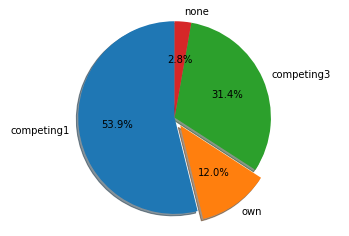

In [9]:
labels = 'competing1','own', 'competing3', 'none'
a = results[results.profit.notnull()].shape[0]
b = results[results.profit1.notnull()].shape[0]
c = results[results.profit3.notnull()].shape[0]
d = results.shape[0] - (a+b+c)
sizes = [b, a, c, d]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [10]:
print('We won {:.1f}% of our bids'.format(a/results[results.own.notnull()].shape[0]*100))
print('Competing1 won {:.1f}% of their bids'.format(b/results[results.competing1.notnull()].shape[0]*100))
print('Competing3 won {:.1f}% of their bids'.format(c/results[results.competing3.notnull()].shape[0]*100))

We won 57.4% of our bids
Competing1 won 57.4% of their bids
Competing3 won 42.7% of their bids


In [88]:
#Join probabilities
sr_prob = pd.read_csv('updated_probs_stage1.csv', index_col = 0)
final = pd.concat([sr_prob, results], axis = 1)
final

,probability,own,competing1,competing3,borrowertype,accepted,default,profit
0,0.291848,NaN,0.405000,0.236840,0,0,0,NaN
1,0.175391,NaN,0.092714,0.152445,2,0,1,NaN
2,0.079274,NaN,0.060536,NaN,0,0,0,NaN
3,0.014177,0.040365,0.159082,0.004469,0,0,0,NaN
4,0.239929,NaN,0.944560,0.297304,3,0,0,NaN
...,...,...,...,...,...,...,...,...
99995,0.059121,0.060634,0.088147,0.165407,0,1,0,606.34381
99996,0.400499,NaN,0.234034,NaN,0,0,0,NaN
99997,0.238915,NaN,0.193021,0.178011,0,0,0,NaN
99998,0.173570,NaN,0.300000,0.125500,0,0,0,NaN


### Default rate if we won all the bids

In [28]:
x = results.copy()
x['rate'] = x.own
x['competing1'] = np.nan
x['competing3'] = np.nan
x['profit'] = x.apply(calculate_profit, axis=1)
x

,own,competing1,competing3,borrowertype,accepted,default,profit,rate
0,NaN,NaN,NaN,0,0,0,NaN,NaN
1,NaN,NaN,NaN,2,0,1,NaN,NaN
2,NaN,NaN,NaN,0,0,0,NaN,NaN
3,0.040365,NaN,NaN,0,0,0,403.65480,0.040365
4,NaN,NaN,NaN,3,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...
99995,0.060634,NaN,NaN,0,1,0,606.34382,0.060634
99996,NaN,NaN,NaN,0,0,0,NaN,NaN
99997,NaN,NaN,NaN,0,0,0,NaN,NaN
99998,NaN,NaN,NaN,0,0,0,NaN,NaN


In [30]:
x[x.own.notnull()][x.default == 1].shape[0]/x[x.own.notnull()].shape[0]

0.04835469676678783

### Actual default rate - Stage 1

In [35]:
results[results.profit.notnull()][results.default == 1].shape[0]/results[results.profit.notnull()].shape[0]

0.06705539358600583

# Simulation function

In [13]:
def total_profit(cut, floor):
    x = final.copy()
    x['rate'] = np.where(x['probability'] < cut, x['probability']/(1-x['probability']) + floor, np.nan)
    x.loc[x["rate"] > 1, "rate"] = 1
    x['profit'] = x.apply(calculate_profit, axis=1)
    profit = x.profit.sum()
    loans = x[x['rate'].notnull()].shape[0]
    wins = x[x['profit'].notnull()].shape[0]
    defaults = x[x['profit'].notnull()][x['default'] == 1].shape[0]
    return profit, loans, wins, defaults

In [14]:
print(total_profit(0.05, 0.04))

(1465415.2445373558, 13702, 4376, 156)


# Scenarios simulation

### After optimizing the Random Forest parameters, we tested different cut (probability above which we wouldn't give loans) and floor (minimum interest rate, considering a 0% probability of default) points.

- We simulated the new interest rates in the market, based on the competitors' rates and borrower preferences.



In [15]:
%%time
#df_profit = pd.DataFrame(columns = ['cut', 'floor', 'profit', 'loans', 'wins'])

d = []
for i in range(1, 51):
    #print(i)
    for j in range(0, 101):
        #print(i, j)
        cut = i*0.01
        floor = j*0.005
        profit, loans, wins, defaults = total_profit(cut, floor)
        d_aux = {}
        d_aux['cut'] = cut
        d_aux['floor'] = floor
        d_aux['profit'] = profit
        d_aux['loans'] = loans
        d_aux['wins'] = wins
        d_aux['defaults'] = defaults
        d.append(d_aux)
        #df_profit.loc[-1] = [cut, floor, profit, loans, wins]
        #df_profit.index = df_profit.index + 1  # shifting index
        #df_profit = df_profit.sort_index()
        
df_profit = pd.DataFrame.from_dict(d)

Wall time: 10h 24min 25s


In [17]:
df_profit.sort_values('profit', ascending = False)

,cut,floor,profit,loans,wins,defaults
4770,0.48,0.115,9.471115e+06,98441,13476,3035
4972,0.50,0.115,9.351115e+06,99061,13588,3097
4871,0.49,0.115,9.351115e+06,98768,13536,3071
4669,0.47,0.115,9.341115e+06,97892,13379,2993
4771,0.48,0.120,9.339074e+06,98441,12794,2931
...,...,...,...,...,...,...
4444,0.45,0.000,-5.947032e+06,96906,45291,7029
4646,0.47,0.000,-5.950889e+06,97892,45512,7131
4545,0.46,0.000,-6.023842e+06,97377,45385,7076
4848,0.49,0.000,-6.080268e+06,98768,45721,7238


In [18]:
#df_profit.to_csv('profit_simulation.csv')

In [19]:
%%time

df_profit = pd.read_csv('profit_simulation.csv', index_col=0)
df_profit['acceptance'] = df_profit['wins']/df_profit['loans']
df_profit['default_rate'] = df_profit.defaults / df_profit.wins
df_profit.sort_values('profit', ascending = False)


Wall time: 48 ms


,cut,floor,profit,loans,wins,defaults,acceptance,default_rate
4770,0.48,0.115,9.471115e+06,98441,13476,3035,0.136894,0.225215
4972,0.50,0.115,9.351115e+06,99061,13588,3097,0.137168,0.227922
4871,0.49,0.115,9.351115e+06,98768,13536,3071,0.137048,0.226876
4669,0.47,0.115,9.341115e+06,97892,13379,2993,0.136671,0.223709
4771,0.48,0.120,9.339074e+06,98441,12794,2931,0.129966,0.229092
...,...,...,...,...,...,...,...,...
4444,0.45,0.000,-5.947032e+06,96906,45291,7029,0.467370,0.155196
4646,0.47,0.000,-5.950889e+06,97892,45512,7131,0.464921,0.156684
4545,0.46,0.000,-6.023842e+06,97377,45385,7076,0.466075,0.155911
4848,0.49,0.000,-6.080268e+06,98768,45721,7238,0.462913,0.158308


# Data visualization

- Graph 1: we can see that the greates profits and losses occur on the highest cut points. This show a great sensitivity on the floor point chosen, that will be further assessed on the second graph.
- Graph 2: now, we can see that low floor points lead to the biggest losses (hence, when combined with high cut points), and the optimal floor point resides between 10 and 13%

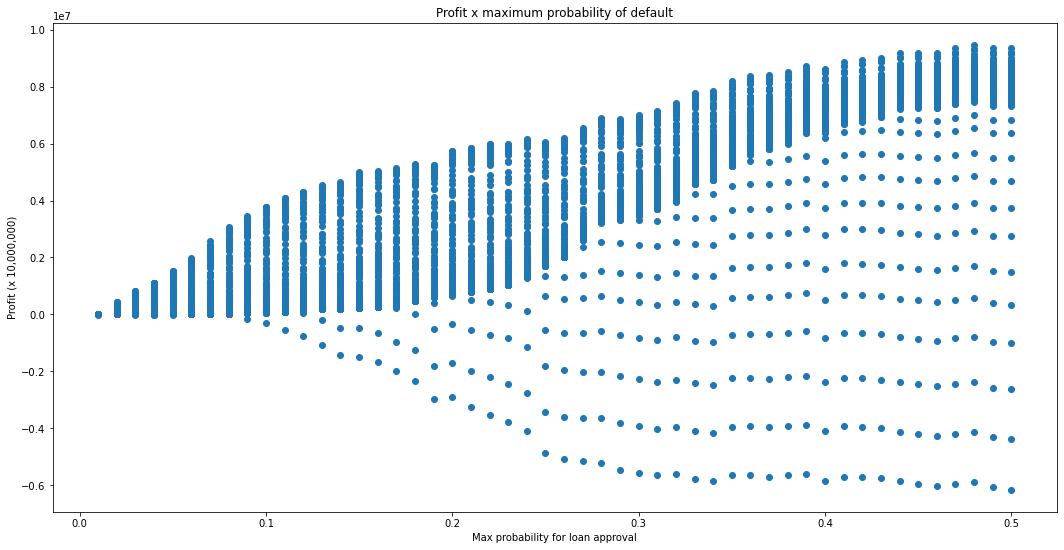

In [36]:
plt.figure(figsize=(18,9))
plt.scatter(df_profit['cut'], df_profit['profit'])
plt.title('Profit x maximum probability of default')
plt.ylabel('Profit (x 10,000,000)')
plt.xlabel('Max probability for loan approval')
plt.show()

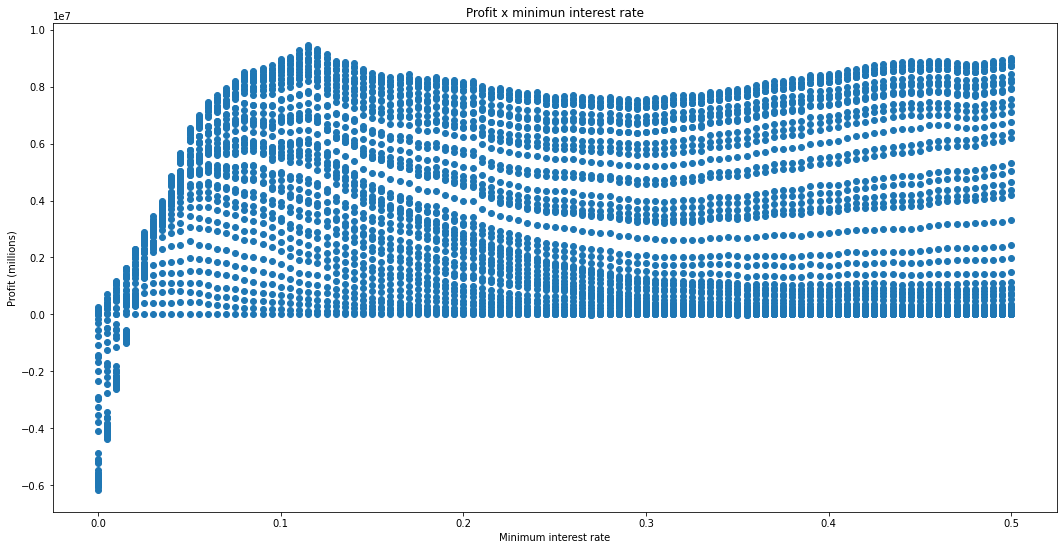

In [21]:
plt.figure(figsize=(18,9))
plt.scatter(df_profit['floor'], df_profit['profit'])
plt.title('Profit x minimun interest rate')
plt.ylabel('Profit (millions)')
plt.xlabel('Minimum interest rate')
plt.show()

In [60]:
df_profit[df_profit['profit']>0].sort_values('acceptance', ascending = False).head(10)

,cut,floor,profit,loans,wins,defaults,acceptance,default_rate
101,0.02,0.000,132225.317031,3205,2085,18,0.650546,0.008633
1,0.01,0.005,2001.004000,253,163,2,0.644269,0.012270
707,0.08,0.000,16466.351165,23520,14916,683,0.634184,0.045790
1112,0.12,0.005,100975.792664,33932,21202,1449,0.624838,0.068343
606,0.07,0.000,245493.125180,20208,12603,488,0.623664,0.038721
1011,0.11,0.005,233307.674220,31269,19408,1224,0.620679,0.063067
505,0.06,0.000,177378.654827,16352,10091,331,0.617111,0.032802
910,0.10,0.005,376323.972712,28478,17406,993,0.611209,0.057049
2,0.01,0.010,8394.526076,253,154,2,0.608696,0.012987
404,0.05,0.000,59710.265054,13702,8274,242,0.603853,0.029248


# Are the default rate or the acceptance rate good metrics for profit??

- According to the simulation, no. The most profitable scenarios scored average in both metrics, but all give loans to virtually everybody with high interest rates

In [37]:
x = df_profit.sort_values('default_rate').reset_index()
print('The most profitable scenario is the {}th smallest default rate from {} scenarios'.format(x.profit.idxmax(), x.shape[0]))

The most profitable scenario is the 2727th smallest default rate from 5050 scenarios


In [38]:
x = df_profit.sort_values('acceptance', ascending = False).reset_index()
print('The most profitable scenario is the {}th biggest acceptance rate from {} scenarios'.format(x.profit.idxmax(), x.shape[0]))

The most profitable scenario is the 1080th biggest acceptance rate from 5050 scenarios


# Run new model to Stage 2 applicants

Using the best Random Forest model found on model_stage1.ipynb

Now, we cant train the model with data from the applicants on Stage 1

In [89]:
def preprocess(df):
    tot = df.copy()
    
    enc = OneHotEncoder(categories='auto') # Create dummy variables
    features = enc.fit_transform(tot[['employment']]).toarray() # Transform categorical into numerical
    names = np.concatenate(enc.categories_) # Transform above variables into column names
    
    l_drop = ['employment','default', 'social1','social3'] # Focus on social2 profiles
    X = pd.DataFrame(features, columns=names) # Create dataframe with dummy variables
    
    # Substitute categorical variable in original dataframe
    X = pd.concat([tot, X],axis=1) 
    X = X.drop(l_drop,axis=1)
    y = tot['default']
    return (X,y)


# Run model and complile results
def runModel(df,regr):
    X, y = preprocess(df)
    
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    cont = 0
    menor = 10000000
    for train_index, test_index in kf.split(X):
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        
        
        aux = X_test.copy()
        aux['default'] = y_test
        aux['probability'] = pred
        
        if cont == 0:
            df_result = aux
        else:
            df_result = pd.concat([df_result, aux])
        cont += 1
    return df_result


def preprocess2(df):
    tot = df.copy()
    
    enc = OneHotEncoder(categories='auto') # Create dummy variables
    features = enc.fit_transform(tot[['employment']]).toarray() # Transform categorical into numerical
    names = np.concatenate(enc.categories_) # Transform above variables into column names
    
    l_drop = ['employment'] # Focus on social2 profiles
    X = pd.DataFrame(features, columns=names) # Create dataframe with dummy variables
    X.index = [x for x in range(200001, 300001)]
    
    # Substitute categorical variable in original dataframe
    X = pd.concat([tot, X],axis=1) 
    X = X.drop(l_drop,axis=1)
    return X

In [90]:
applicants_st1 = final.copy()
x = pd.read_csv('LoanApplications_Stage1_Lender2.csv', index_col = 0)
applicants_st1.index = [x for x in range(100001, 200001)]
applicants_st1 = pd.concat([x, applicants_st1.default], axis=1)
applicants_st1

,sex,employment,marital,income,social2,default
100001,1,employed,1,7787,0.521474,0
100002,1,retired,1,9286,0.072545,1
100003,1,employed,1,25586,0.193502,0
100004,1,employed,1,57661,0.904576,0
100005,1,retired,0,3943,0.325358,0
...,...,...,...,...,...,...
199996,1,retired,0,22188,0.000000,0
199997,1,student,0,0,0.391565,0
199998,1,employed,1,5615,0.834428,0
199999,1,unemployed,1,16573,0.318897,0


In [91]:
df_total = pd.read_csv('PastLoans.csv', index_col = 0)
df_total = pd.concat([df_total, applicants_st1]).reset_index().drop('index', axis = 1)
df_total

,sex,employment,marital,income,social1,social2,social3,default
0,1,unemployed,0,5458,0.028116,0.983725,0.732502,0
1,1,employed,1,26108,0.638239,0.592502,0.615449,0
2,1,employed,1,11810,0.240542,0.630370,0.174645,0
3,1,unemployed,1,5375,0.648089,0.000000,0.216376,0
4,0,retired,1,3459,0.360834,0.000000,0.346708,1
...,...,...,...,...,...,...,...,...
199995,1,retired,0,22188,NaN,0.000000,NaN,0
199996,1,student,0,0,NaN,0.391565,NaN,0
199997,1,employed,1,5615,NaN,0.834428,NaN,0
199998,1,unemployed,1,16573,NaN,0.318897,NaN,0


In [92]:
start_time = time.time()

df = pd.read_csv('LoanApplications_Stage2_Lender2.csv', index_col = 0)
regr = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=10,n_estimators=500, random_state=1)

X, y = preprocess(df_total)
regr.fit(X, y)
df['probability'] = regr.predict(preprocess2(df))

print("--- {:.2f} seconds ---".format(time.time() - start_time))
df

--- 107.58 seconds ---


,sex,employment,marital,income,social2,probability
id,,,,,,
200001,1,employed,1,8068,0.635025,0.232072
200002,1,employed,1,7484,0.527458,0.277122
200003,1,employed,0,12388,0.846696,0.114211
200004,0,employed,1,77288,0.000000,0.034160
200005,1,employed,1,9978,0.000000,0.215000
...,...,...,...,...,...,...
299996,1,student,0,15292,0.872035,0.031901
299997,0,unemployed,0,0,0.538252,0.430463
299998,1,employed,1,13037,0.789792,0.102425


In [100]:
df['rate'] = np.where(df['probability'] < 0.48, df['probability']/(1-df['probability']) + 0.115, None)
df.loc[df["rate"] > 1, "rate"] = 1
df

,sex,employment,marital,income,social2,probability,rate
id,,,,,,,
200001,1,employed,1,8068,0.635025,0.232072,0.417206
200002,1,employed,1,7484,0.527458,0.277122,0.49836
200003,1,employed,0,12388,0.846696,0.114211,0.243937
200004,0,employed,1,77288,0.000000,0.034160,0.150369
200005,1,employed,1,9978,0.000000,0.215000,0.388886
...,...,...,...,...,...,...,...
299996,1,student,0,15292,0.872035,0.031901,0.147952
299997,0,unemployed,0,0,0.538252,0.430463,0.870813
299998,1,employed,1,13037,0.789792,0.102425,0.229113


In [102]:
df.drop('probability', axis = 1).to_csv('pyce_loans_stage2.csv')